<h1>Customer Churn</h1>

Hier wird es darum gehen, ob Kunden bei bestimmten Bedingungen ehe dazu neigen, die Bank zu verlassen.

Es werden einige Visualisierungen gezeigt und die Daten werden bereinigt. Später soll das Model mit Flask verfügbar gemacht werden.

Dataset:

> Bank Customer Churn Dataset: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset [Letzter Zugriff: 03.07.2024]

In [342]:
# Imports.
import pandas  as pd
import numpy   as np
import seaborn as sn

import matplotlib.pyplot as plt

from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.svm          import SVC

<h2>Explore</h2>

In [32]:
# Lade CSV.
churn_df = pd.read_csv('./data/archive.zip', compression='zip')
churn_df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [33]:
# 12 Features und 10.000 Einträge.
churn_df.shape

(10000, 12)

In [34]:
churn_df.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

Die meisten Features sind schon numerisch. <br>
Das Feature "customer_id" liefert uns keinen Mehrwert, also wird es gedropt. 

In [35]:
churn_df.drop(['customer_id'], axis='columns', inplace=True)
churn_df.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [36]:
# Nutze unique(), um Werte von bestimmten Spalten anzuzeigen. 
# - np.setdiff1d: löscht Einträge die wir nicht brauchen.
for col in np.setdiff1d(churn_df.columns, ['age', 'balance', 'balance', 'estimated_salary', 'credit_score']):
    print(f'{col}:')
    print(churn_df[col].unique())

active_member:
[1 0]
churn:
[1 0]
country:
['France' 'Spain' 'Germany']
credit_card:
[1 0]
gender:
['Female' 'Male']
products_number:
[1 3 2 4]
tenure:
[ 2  1  8  7  4  6  3 10  5  9  0]


In [37]:
churn_df.isnull().sum()

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

Als Nächstes müssen die nicht-numerischen Features codiert werden. 

In [38]:
target   = ['France', 'Spain', 'Germany'] 
ersetzen = [0, 1, 2]

for target, replace in zip(target, ersetzen):
    churn_df.replace(target, replace, inplace=True)

churn_df['country'].values

C:\Users\Alexander\AppData\Local\Temp\ipykernel_20572\1410523213.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churn_df.replace(target, replace, inplace=True)


array([0, 1, 0, ..., 0, 2, 0], dtype=int64)

In [40]:
# On-Hot Encode Gender
churn_df['gender'] = pd.get_dummies(churn_df['gender'], drop_first=True, dtype='int')
# Female: 0, Male: 1
churn_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,1,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,1,0,43,2,125510.82,1,1,1,79084.10,0


In [41]:
churn_df.dtypes

credit_score          int64
country               int64
gender                int32
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

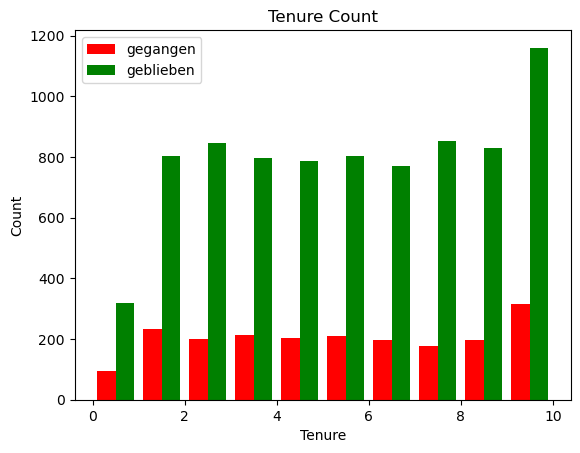

In [47]:
# tenure: Wie lange ist diese Person ein Kunde gewesen?
# - In Jahren, siehe Dataset Beschreibung.

plt.title("Tenure Count")
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.hist([ churn_df[churn_df['churn']==1].tenure, churn_df[churn_df['churn']==0].tenure ], \
        color=['red', 'green'],  label=['gegangen', 'geblieben'])
plt.legend()

In [52]:
# Sind die Klassen ausgeglichen? 
churn_df['churn'].value_counts()

churn
0    7963
1    2037
Name: count, dtype: int64

C:\Users\Alexander\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age', ylabel='Count'>

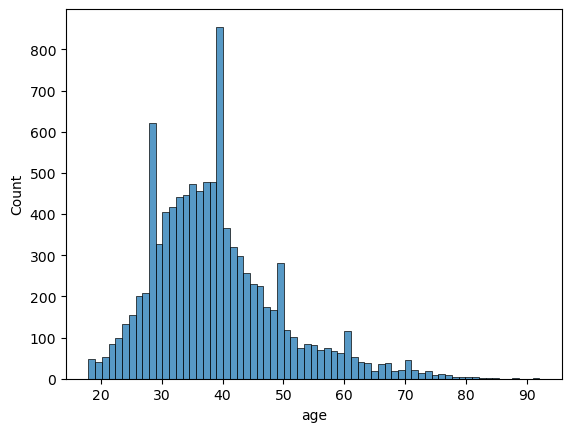

In [111]:
# Wie ist das Alter aufgeteilt? 
sn.histplot(churn_df['age'])

Customer Churn Datasets sind meist unbalanciert. Später werden wir es mit einer Methode balancieren.

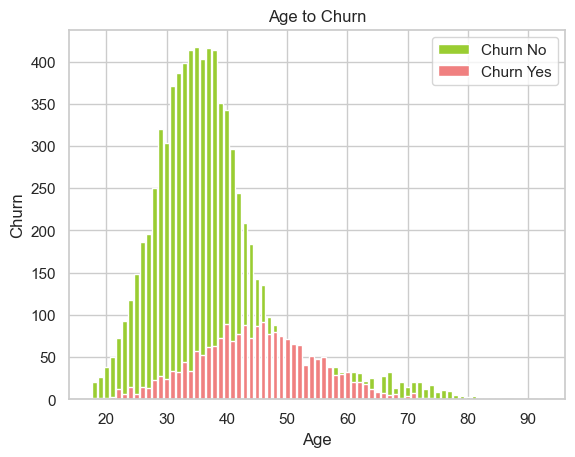

In [247]:
# Age zu Churn.

# Wie viele sind im Alter gegangen?
plt.title("Age to Churn")
plt.xlabel("Age")
plt.ylabel('Churn')

churn_yes = churn_df[['age', 'churn']].loc[churn_df['churn']==1].groupby('age')['churn'].value_counts().unstack(fill_value=0)
churn_no = churn_df[['age', 'churn']].loc[churn_df['churn']==0].groupby('age')['churn'].value_counts().unstack(fill_value=0)
plt.bar(churn_no.index,  churn_no[0],   label='Churn No',  color="yellowgreen")
plt.bar(churn_yes.index, churn_yes[1],  label='Churn Yes', color="lightcoral")
plt.legend()

Auf diesem Plot sieht man, dass das Alter der Personen hauptsächlich in dem Bereich 25 bis 60 liegt. Die jüngeren Leute bleiben eher und ab dem Alter von 35 steigt die Anzahl der die Gehen. Ab da könnte man diesen Leuten Angebote unterbreiten, um diese zum Bleiben anzuregen.

Man sieht auch einige Wucherungen nach rechts, wo es wenig Daten gibt. Weit rechts stehende Werte sind Outlier.

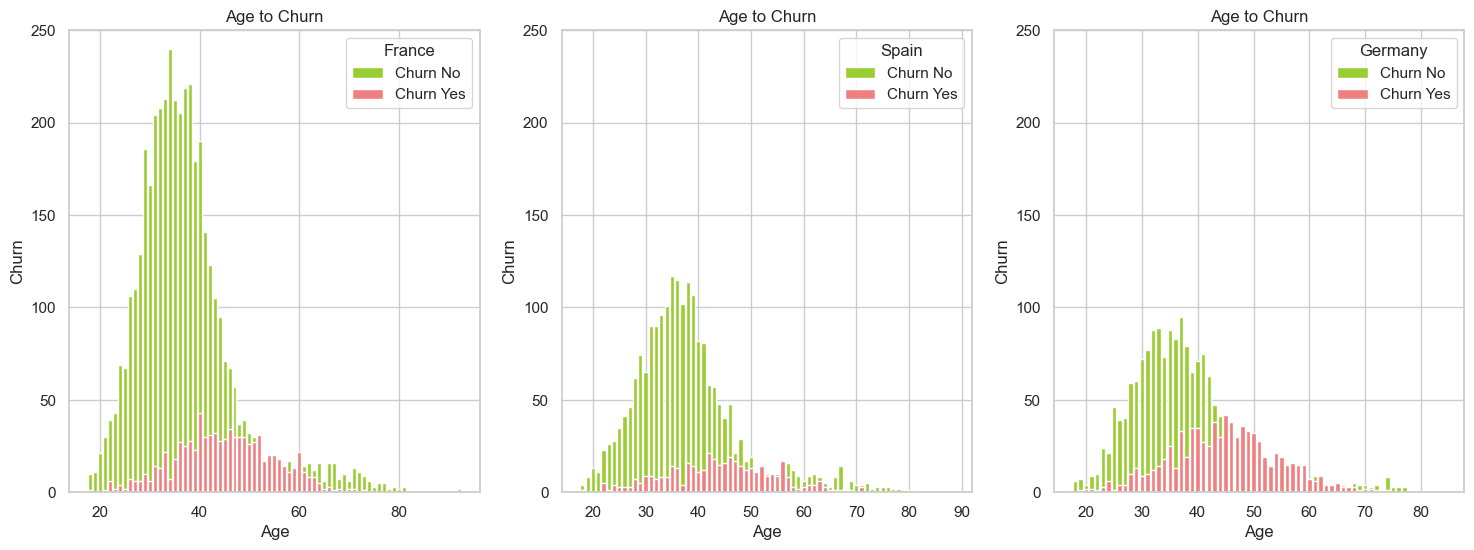

In [246]:
## Plot: Age to Churn gruppiert nach Ländern. 
country = ['France', 'Spain', 'Germany'] 

fig, axs = plt.subplots(1,3, figsize=(18, 6))
axs = axs.ravel()

for i in range(3):
    churn_no  = churn_df[['age', 'churn', 'country']].loc[(churn_df['churn']==0) & (churn_df['country']==i) ].groupby('age')['churn'].value_counts().unstack(fill_value=0)
    churn_yes = churn_df[['age', 'churn', 'country']].loc[(churn_df['churn']==1) & (churn_df['country']==i) ].groupby('age')['churn'].value_counts().unstack(fill_value=0)
    axs[i].set_title("Age to Churn")
    axs[i].set_xlabel('Age')
    axs[i].set_ylabel('Churn')
    axs[i].set_ylim(0, 250)
    axs[i].bar(churn_no.index,  churn_no[0],    label='Churn No',  color="yellowgreen")
    axs[i].bar(churn_yes.index,  churn_yes[1],  label='Churn Yes', color="lightcoral")
    axs[i].legend(title=country[i])

Durch das Spezifizieren der Länder kann untersucht werden, welche Gegebenheiten dazu führen, dass Leute bleiben oder gehen. Das ist wichtig, da in jedem Land andere Regeln gelten und Menschen sich anders verhalten mögen, doch gibt es Ähnlichkeiten.

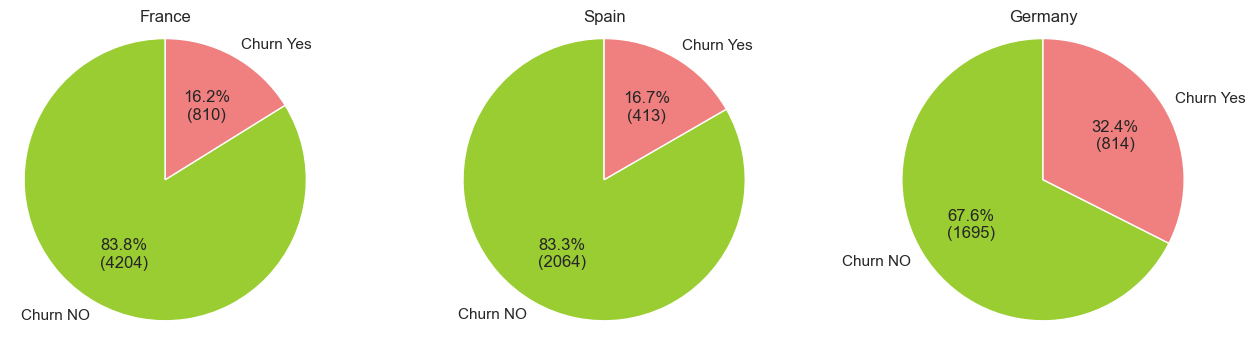

In [304]:
## Plot: Übersicht als Piechart. 
fig, axs = plt.subplots(1,3, figsize=(14, 5))
fig.tight_layout(pad=5.0)
axs = axs.ravel()

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

for i in range(3):
    churn_no  = churn_df[['churn', 'country']].loc[(churn_df['churn']==0) & (churn_df['country']==i) ].groupby('country').value_counts().unstack(fill_value=0)
    churn_yes = churn_df[['churn', 'country']].loc[(churn_df['churn']==1) & (churn_df['country']==i) ].groupby('country').value_counts().unstack(fill_value=0)
    axs[i].set_title(country[i])
    axs[i].pie([np.sum( churn_no[0].values ), np.sum( churn_yes[1].values )],\
               startangle=90, colors=["yellowgreen", 'lightcoral'], labels=['Churn NO', 'Churn Yes'], autopct=lambda pct: func(pct, np.sum( churn_no[0].values ) + np.sum( churn_yes[1].values )))
    axs[i].axis('equal')

([<matplotlib.patches.Wedge at 0x276fda94610>,
 [Text(-0.6568642010431011, -0.8823431426537006, 'Churn NO'),
  Text(0.6568642010431012, 0.8823431426537006, 'Churn Yes')],
 [Text(-0.3582895642053278, -0.4812780778111093, '79.6%\n(7963)'),
  Text(0.35828956420532787, 0.4812780778111093, '20.4%\n(2037)')])

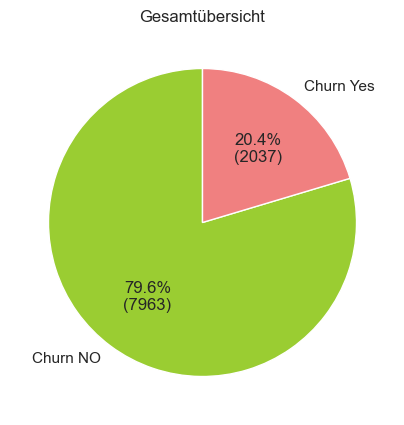

In [313]:
## Plot: Gesamtüberblick.
plt.figure(figsize=(14, 5))
  
churn_no  = churn_df['churn'].value_counts()[0]
churn_yes = churn_df['churn'].value_counts()[1]
plt.title("Gesamtübersicht")
plt.pie([churn_no, churn_yes],\
               startangle=90, colors=["yellowgreen",'lightcoral'], labels=['Churn NO', 'Churn Yes'], autopct=lambda pct: func(pct, churn_no + churn_yes))
    

Wir können uns weitere Einzelheiten anschauen.

In [314]:
churn_df.describe()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.749500,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,0.830433,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,0.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,2.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
// # Content coming

Jetzt kümmern wir uns um mögliche Outlier. Dafür können wir z. B. Percentiles nutzen.

<Axes: xlabel='credit_score'>

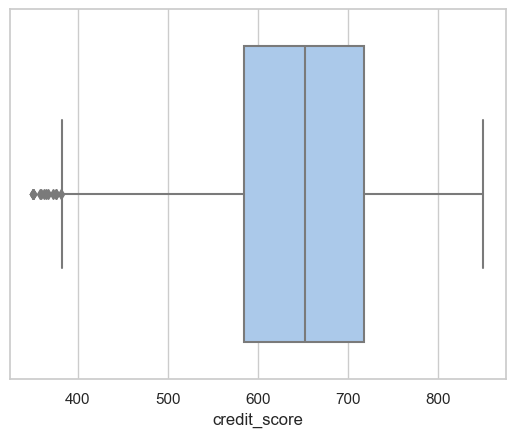

In [336]:
target = ['credit_score'] 
sn.boxplot(x=churn_df['credit_score'], palette="pastel" )

In [337]:
# Durch die Angabe von Quantile können diese 3 Features gefiltert werden. 

filtered_df = churn_df.copy()

for col in target:  
    threshold_high = churn_df[col].quantile(0.98)
    threshold_low  = churn_df[col].quantile(0.02)

    filtered_df = filtered_df[ (filtered_df[col] > threshold_low) & (filtered_df[col] < threshold_high ) ] 

filtered_df.shape

(9563, 11)

In [ ]:
// # Content coming

<h2>Training</h2>

Jetzt erstellen wir das Dataset für das Training. Vorher werden wir noch die Daten skalieren.

In [338]:
X, y = filtered_df.drop(['churn'], axis='columns'), filtered_df['churn']

In [339]:
X.shape

(9563, 10)

In [340]:
scaler   = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.41919192, 0.        , 0.        , ..., 1.        , 1.        ,
        0.50673489],
       [0.39141414, 0.5       , 0.        , ..., 0.        , 1.        ,
        0.56270874],
       [0.12373737, 0.        , 0.        , ..., 1.        , 0.        ,
        0.56965435],
       ...,
       [0.64646465, 0.        , 0.        , ..., 0.        , 1.        ,
        0.21039009],
       [0.80555556, 1.        , 1.        , ..., 1.        , 0.        ,
        0.46442905],
       [0.85606061, 0.        , 0.        , ..., 1.        , 0.        ,
        0.19091423]])

In [343]:
# Erstelle Train- und Testset.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.12)

Es gibt 3 Modelle mit verschiedenen Parametern, die wir testen werden.